<a href="https://colab.research.google.com/github/Flurame/ML4/blob/main/main1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, classification_report, multilabel_confusion_matrix
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Настройки визуализаций
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Загрузка данных
df = pd.read_csv("data.csv")
df = df.drop_duplicates()

In [26]:


# Мягкая очистка текста — оставляем цифры, не удаляем стоп-слова и не лемматизируем
def clean_text_soft(text):
    text = str(text).lower()
    text = re.sub(r"[^а-яёa-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [27]:


# Применение предобработки
if 'text' in df.columns:
    df['text_clean'] = df['text'].apply(clean_text_soft)
else:
    df['text_clean'] = df.iloc[:, 0].apply(clean_text_soft)

In [28]:

# Удаляем строки с пустыми текстами после очистки
df = df[df['text_clean'].str.strip().astype(bool)]

In [29]:
# Выделение меток
labels = ['Нравится скорость отработки заявок',
          'Нравится качество выполнения заявки',
          'Нравится качество работы сотрудников',
          'Понравилось выполнение заявки',
          'Вопрос решен']

for label in labels:
    if label not in df.columns:
        df[label] = 0

y = df[labels]

In [30]:

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text_clean'])

In [31]:

# Модели для сравнения
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(solver='liblinear')),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "XGBoost": OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [32]:

# Обучение и оценка моделей
for name, model in models.items():
    print(f"\n--- {name} ---")
    auc_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred, average='macro')
        auc_scores.append(auc)
    print("Средний ROC-AUC:", np.mean(auc_scores))



--- Logistic Regression ---
Средний ROC-AUC: 0.3884161672499902

--- Random Forest ---
Средний ROC-AUC: 0.4209239499730796

--- XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Средний ROC-AUC: 0.5


In [33]:

# Финальный отчет по последней модели (XGBoost)
final_model = models["XGBoost"]
final_model.fit(X_train, y_train)
y_pred_bin = (np.array(final_model.predict_proba(X_test)) >= 0.5).astype(int)
print("\nClassification report (XGBoost):")
print(classification_report(y_test, y_pred_bin, target_names=labels))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:55:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification report (XGBoost):
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.00      0.00      0.00        45
 Нравится качество выполнения заявки       0.00      0.00      0.00         9
Нравится качество работы сотрудников       0.00      0.00      0.00        13
       Понравилось выполнение заявки       0.00      0.00      0.00        93
                        Вопрос решен       0.00      0.00      0.00       136

                           micro avg       0.00      0.00      0.00       296
                           macro avg       0.00      0.00      0.00       296
                        weighted avg       0.00      0.00      0.00       296
                         samples avg       0.00      0.00      0.00       296



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

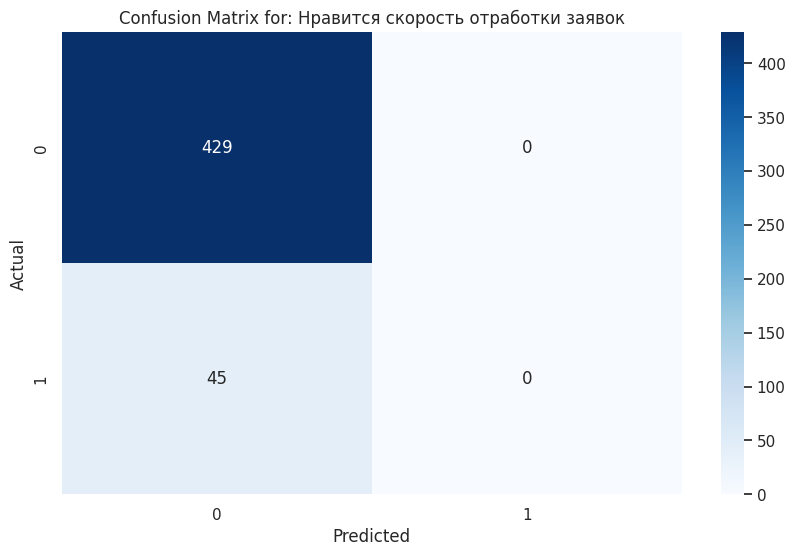

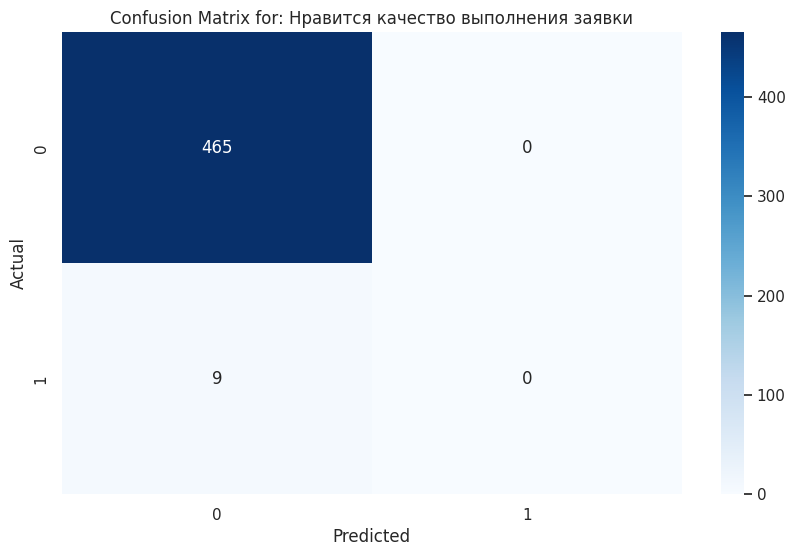

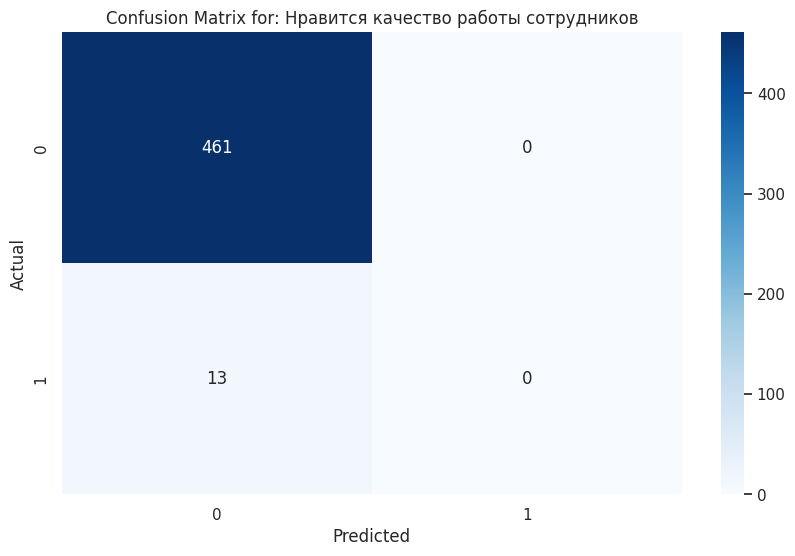

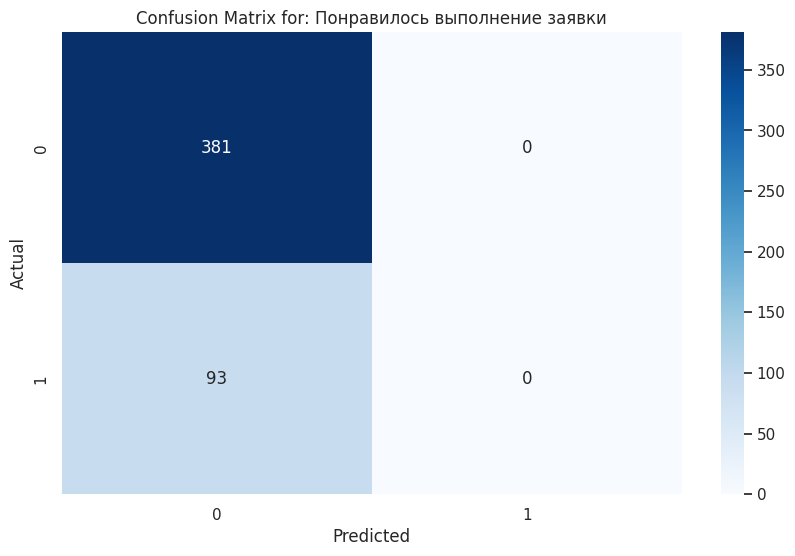

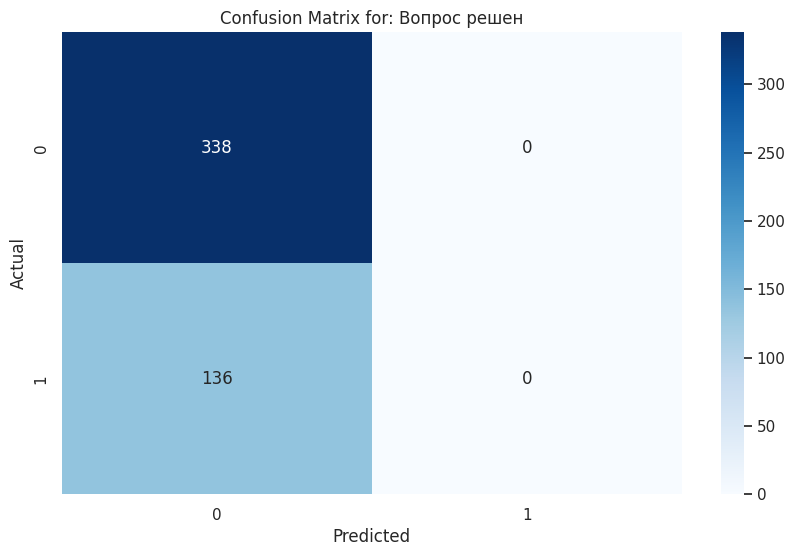

In [34]:
# Матрицы ошибок
mcm = multilabel_confusion_matrix(y_test, y_pred_bin)
for i, label in enumerate(labels):
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

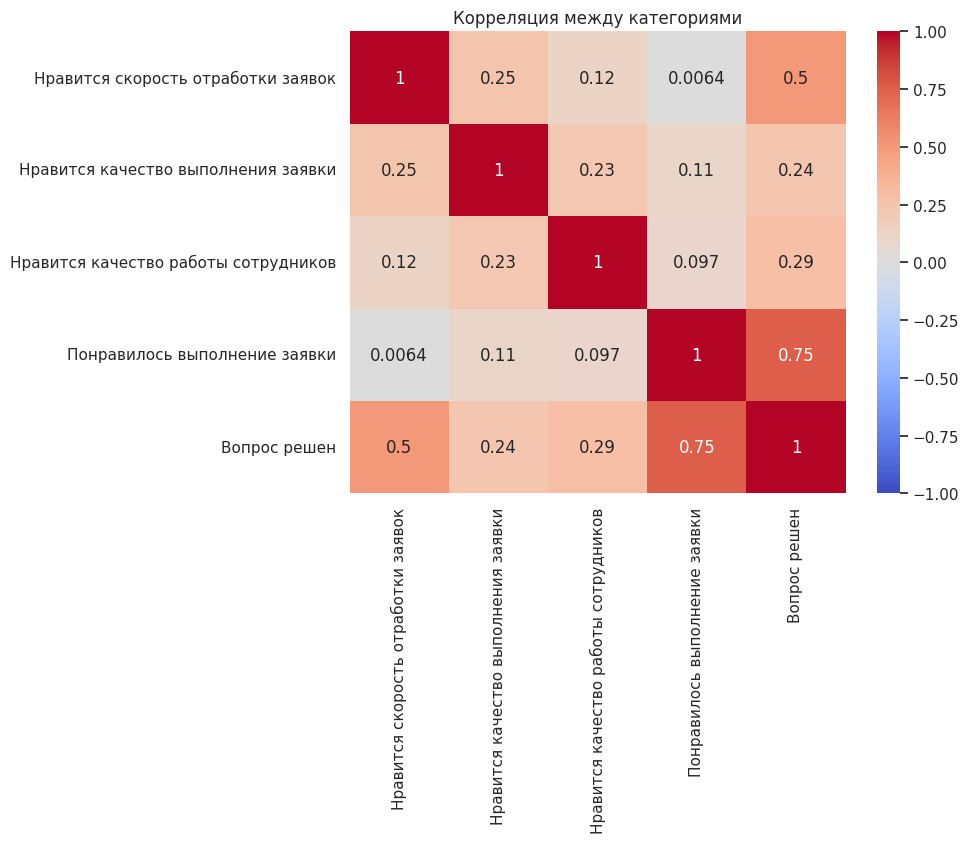

In [35]:

# Матрица корреляции меток
plt.figure(figsize=(8, 6))
sns.heatmap(y.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляция между категориями")
plt.show()

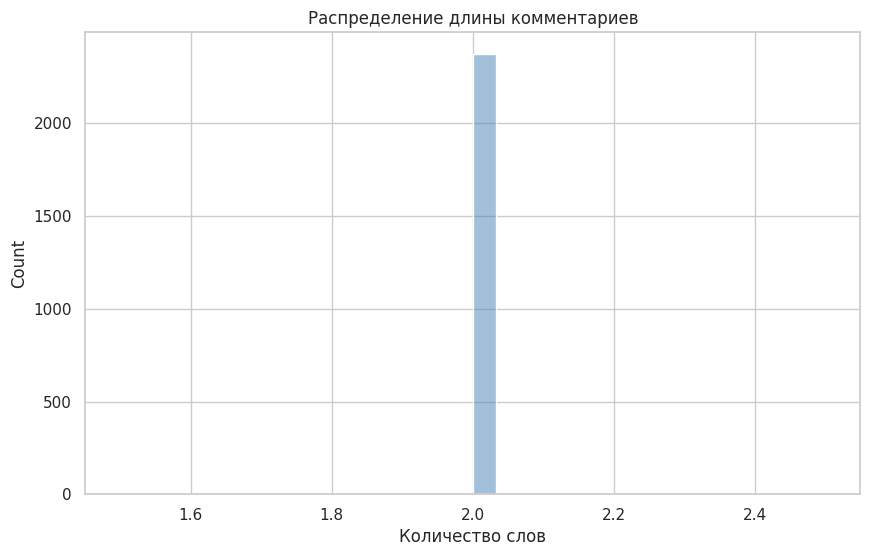

In [36]:

# Длина комментариев
df['text_length'] = df['text_clean'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=30, kde=True, color="steelblue")
plt.title("Распределение длины комментариев")
plt.xlabel("Количество слов")
plt.show()


<ipython-input-37-8c04a1ca7e9d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")


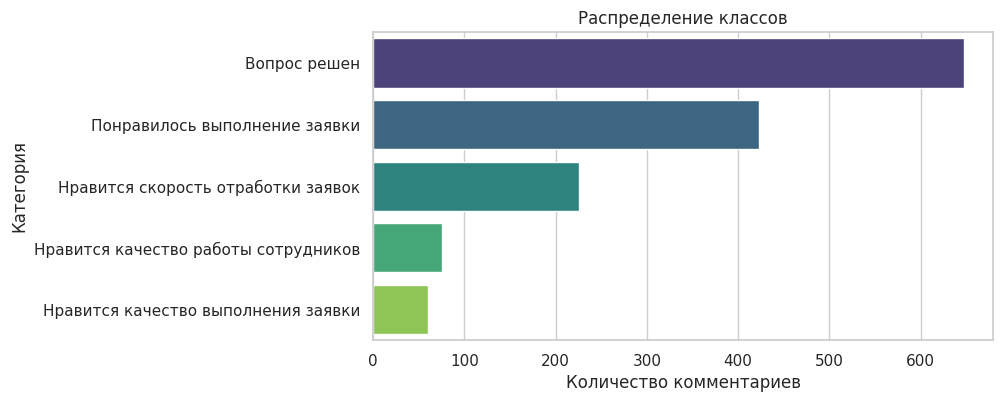

In [37]:
# Распределение меток
label_counts = y.sum().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
plt.title("Распределение классов")
plt.xlabel("Количество комментариев")
plt.ylabel("Категория")
plt.show()

<ipython-input-38-0dc151c74bd7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="magma")


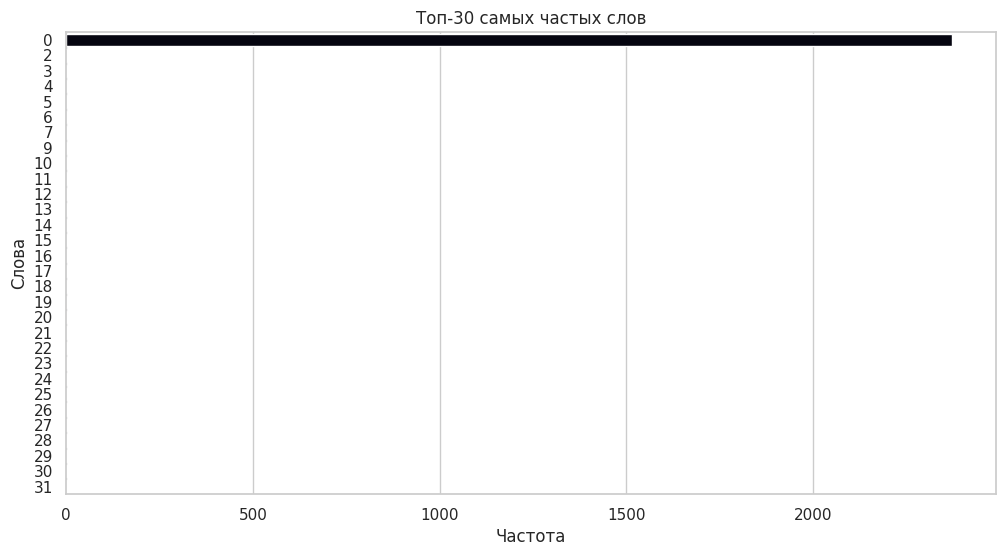

In [38]:

# Топ-30 слов
all_words = ' '.join(df['text_clean']).split()
common_words = Counter(all_words).most_common(30)
words, counts = zip(*common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette="magma")
plt.title("Топ-30 самых частых слов")
plt.xlabel("Частота")
plt.ylabel("Слова")
plt.show()

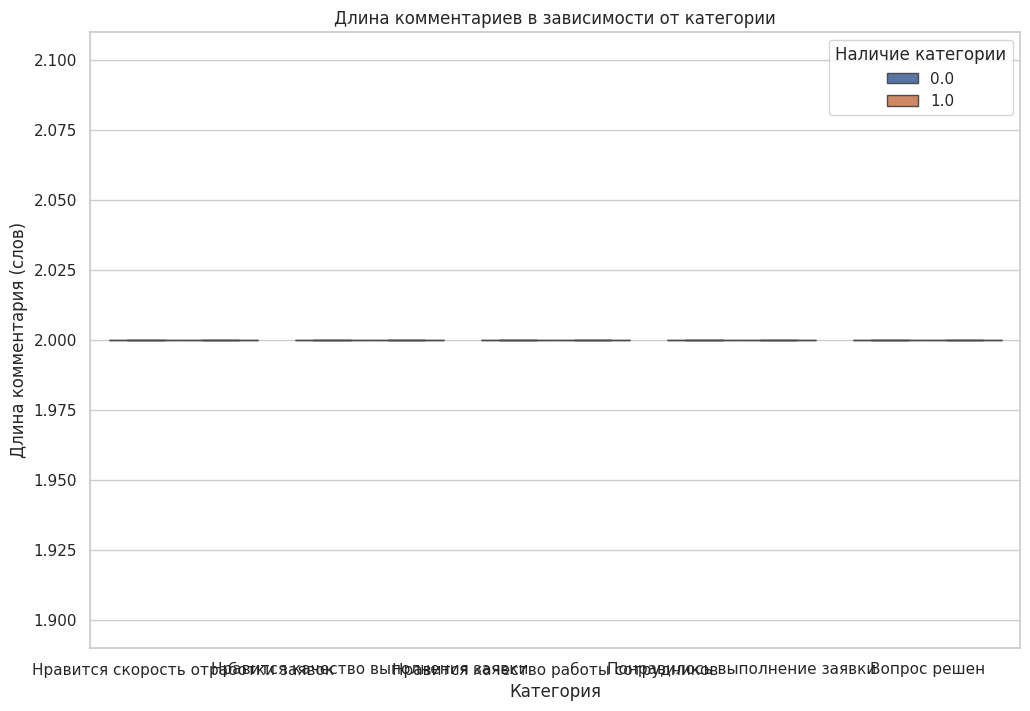

In [39]:
# Boxplot длины по меткам
plt.figure(figsize=(12,8))
sns.boxplot(data=pd.melt(df, id_vars=['text_length'], value_vars=labels),
            x='variable', y='text_length', hue='value')
plt.title("Длина комментариев в зависимости от категории")
plt.xlabel("Категория")
plt.ylabel("Длина комментария (слов)")
plt.legend(title='Наличие категории', loc='upper right')
plt.show()
